In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing
price_list = processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Dec 1 2022', days=30)
print(price_list[0:10])

[{'DOT': 5.47, 'ETH': 1294.57, 'BTC': 17165.39, 'DOGE': 0.10677}, {'DOT': 5.47, 'ETH': 1294.09, 'BTC': 17162.31, 'DOGE': 0.1067}, {'DOT': 5.47, 'ETH': 1294.09, 'BTC': 17160.06, 'DOGE': 0.1067}, {'DOT': 5.47, 'ETH': 1294.83, 'BTC': 17163.71, 'DOGE': 0.10679}, {'DOT': 5.48, 'ETH': 1295.5, 'BTC': 17172.45, 'DOGE': 0.10683}, {'DOT': 5.48, 'ETH': 1295.47, 'BTC': 17177.28, 'DOGE': 0.10685}, {'DOT': 5.48, 'ETH': 1295.57, 'BTC': 17177.43, 'DOGE': 0.1071}, {'DOT': 5.48, 'ETH': 1295.86, 'BTC': 17178.67, 'DOGE': 0.10723}, {'DOT': 5.48, 'ETH': 1295.57, 'BTC': 17175.19, 'DOGE': 0.10722}, {'DOT': 5.48, 'ETH': 1295.8, 'BTC': 17176.2, 'DOGE': 0.10761}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, extra_trade_volume, random_swaps, steady_swaps
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

# parameter_ranges = {
#     'lrna_amp': (0.1, 2, 1),
#     'lrna_decay': (0.000005, 0.00005, 1),
#     'lrna_max': (0.1, 0.4, 1),
#     'asset_amp': (0.1, 2, 1),
#     'asset_decay': (0.000005, 0.0001, 1),
#     'asset_max': (0.3, 0.5, 1),
#     'oracle_length': (5, 500, 1)
# }

# parameter_ranges = {
#     'lrna_amp': (1, 2, 1),
#     'lrna_decay': (0.0000007, 0.00005, 1),
#     'lrna_max': (0.4, 0.4, 1),
#     'asset_amp': (1, 2, 1),
#     'asset_decay': (0.0000007, 0.0001, 1),
#     'asset_max': (0.4, 0.5, 1),
#     'oracle_length': (5, 500, 1)
# }
#
# parameters = {
#     'lrna_amp': [0.2/5 * (i + 1) for i in range(10)],
#     'lrna_decay': [0.000002 * (i + 1) for i in range(10)],
#     'lrna_max': [0.1]*10,
#     'asset_amp': [0.2 * (i + 1) for i in range(10)],
#     'asset_decay': [0.00001 * (i + 1) for i in range(10)],
#     'asset_max': [0.4]*10,
#     'oracle_length': [5]*10
# }
#
# n = 10
# parameters = {
#     'lrna_amp': [.02]*n,
#     'lrna_decay': [0.000002 * (i + 1) for i in range(n)],
#     'lrna_max': [0.1]*n,
#     'asset_amp': [0.1]*n,
#     'asset_decay': [0.00001 * (i + 1) for i in range(n)],
#     'asset_max': [0.4]*n,
#     'oracle_length': [5]*n
# }

# so far, decay / amp = 0.0005 seems to work well
# i.e. decay = 0.0005 * amp
# lrna vars = asset vars / 5 (but we haven't tested anything else)
# lrna amp of 0.02 and asset amp of 0.1 worked best initially but we will re-test...
# after retesting it looks like lrna amp of 0.06 and asset amp of 0.3 work well

n = 10
parameters = {
    'lrna_amp': [0.01 * (i + 1) for i in range(n)],
    'lrna_max': [0.1]*n,
    'asset_max': [0.4]*n,
    'oracle_length': [5]*n
}
parameters['lrna_decay'] = [0.0005 * i for i in parameters['lrna_amp']]
parameters['asset_amp'] = [0.36 - i for i in parameters['lrna_amp']]
parameters['asset_decay'] = [0.0005 * i for i in parameters['asset_amp']]

static_asset_fees = [0.0025, 0.005, 0.01, 0.02, 0.05, 0.40]
static_lrna_fees = [0.0005, 0.001, 0.002, 0.004, 0.01, 0.10]


def pass_along(min_value, max_value, steps, current):
    return min_value + (max_value - min_value) * current ** 2 / (steps - 1) ** 2 if steps > 1 else min_value

# result_key = []
# for a in range(parameter_ranges['lrna_amp'][2]):
#     for b in range(parameter_ranges['lrna_decay'][2]):
#         for c in range(parameter_ranges['lrna_max'][2]):
#             for d in range(parameter_ranges['asset_amp'][2]):
#                 for e in range(parameter_ranges['asset_decay'][2]):
#                     for f in range(parameter_ranges['asset_max'][2]):
#                         for g in range(parameter_ranges['oracle_length'][2]):
#                             result_key.append ((
#                                 pass_along(*parameter_ranges['lrna_amp'], a),
#                                 pass_along(*parameter_ranges['lrna_decay'], b),
#                                 pass_along(*parameter_ranges['lrna_max'], c),
#                                 pass_along(*parameter_ranges['asset_amp'], d),
#                                 pass_along(*parameter_ranges['asset_decay'], e),
#                                 pass_along(*parameter_ranges['asset_max'], f),
#                                 pass_along(*parameter_ranges['oracle_length'], g)
#                             ))
#

result_key = []
for i in range(n):
    result_key.append ((
        parameters['lrna_amp'][i],
        parameters['lrna_decay'][i],
        parameters['lrna_max'][i],
        parameters['asset_amp'][i],
        parameters['asset_decay'][i],
        parameters['asset_max'][i],
        parameters['oracle_length'][i]
    ))

random.shuffle(result_key)
print (f'trying {len(result_key)} total parameter combinations...')

trying 10 total parameter combinations...


In [3]:
from hydradx.model.amm.trade_strategies import back_and_forth, trade_to_slippage

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20},
    'DOGE': {'usd price': price_list[0]['DOGE'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            # lrna_fee=dynamicadd_lrna_fee(
            #     minimum=0.0005,
            #     amplification=1,
            #     raise_oracle_name='fee_raise',
            #     decay=0.00001,
            #     fee_max=0.1,
            # ),
            # asset_fee=dynamicadd_asset_fee(
            #     minimum=0.0025,
            #     amplification=0.2,
            #     raise_oracle_name='fee_raise',
            #     decay=0.00005,
            #     fee_max=0.4,
            # ),
            lrna_fee=static_lrna_fees[0],
            asset_fee=static_asset_fees[0],
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'ETH': 1000000000, 'BTC': 3000000000, 'DOGE': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=trade_to_slippage(pool_id='omnipool', slippage=0.01, trade_chance=(1e-4)/3.5)
        ),
        'Trader2': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'ETH': 1000000000, 'BTC': 3000000000, 'DOGE': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3
            )
            # +
            # extra_trade_volume('omnipool', percent_of_arb=50)
        ),

        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all = False
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')

class FeeParams:
    def __init__(self, lrna_amp: float, lrna_decay: float, lrna_max: float, asset_amp: float, asset_decay: float, asset_max: float, oracle_length: float, holdings: float):
        self.lrna_amp = lrna_amp
        self.lrna_decay = lrna_decay
        self.lrna_max = lrna_max
        self.asset_amp = asset_amp
        self.asset_decay = asset_decay
        self.asset_max = asset_max
        self.oracle_length = oracle_length
        self.holdings = holdings
        
    def __repr__(self):
        return (
            f'lrna fee amplification: {self.lrna_amp}\n'
            f'lrna fee decay: {self.lrna_decay}\n'
            f'lrna fee max: {self.lrna_max}\n'
            f'asset fee amplification: {self.asset_amp}\n'
            f'asset fee decay: {self.asset_decay}\n'
            f'asset fee max: {self.asset_max}\n'
            f'oracle length: {self.oracle_length}\n'
            f'LP final holdings: {self.holdings}\n'
        )
    
    def csv(self):
        return ', '.join([
            str(self.lrna_amp), 
            str(self.lrna_decay), 
            str(self.lrna_max), 
            str(self.asset_amp), 
            str(self.asset_decay), 
            str(self.asset_max), 
            str(self.oracle_length),
            str(self.holdings)
        ])
    
# load existing results
test_results = []

# path = './output/dynamic_fees_comparison_results.csv'
path = './output/dynamic_fees_comparison_results_colin.csv'
# if os.path.exists(path):
#     # pick up where we left off
#     with open(path, 'r') as file:
#         data = [FeeParams(*[float(num) for num in line.split(',')]) for line in file.readlines()]
#         test_results = data
#
#     print ('last result (from file) \n', test_results[-1])
#     # print ('next up:', FeeParams(*result_key[len(test_results)], 0))


# for key in result_key[len(test_results):]:
events_list = []
for i in range(len(static_asset_fees)):
    random.seed(42)
    test_state = initial_state.copy()
    # test_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    #     minimum=0.0005,
    #     amplification=key[0],
    #     raise_oracle_name='fee_raise',
    #     decay=key[1],
    #     fee_max=key[2],
    # )
    #
    # test_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    #     minimum=0.0025,
    #     amplification=key[3],
    #     raise_oracle_name='fee_raise',
    #     decay=key[4],
    #     fee_max=key[5],
    # )
    # test_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (key[6] + 1)

    test_state.pools['omnipool'].lrna_fee = static_lrna_fees[i]
    test_state.pools['omnipool'].asset_fee = static_asset_fees[i]

    events = run.run(test_state, time_steps=time_steps)
    events_list.append(events)
    # print(events[-1])
    LP_returns = cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)
    # test_results.append(FeeParams(*key, LP_returns))
    # print(key)
    print(i)
    print(static_asset_fees[i])
    print(f'returns = {LP_returns}')
    
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 215859 time steps
Starting simulation...
Execution time: 27.904 seconds.
0
0.0025
returns = 897157.0376813924
Starting simulation...
Execution time: 27.859 seconds.
1
0.005
returns = 889784.9754359174
Starting simulation...
Execution time: 26.575 seconds.
2
0.01
returns = 874433.0793045522
Starting simulation...
Execution time: 28.628 seconds.
3
0.02
returns = 875694.6143837739
Starting simulation...
Execution time: 26.644 seconds.
4
0.05
returns = 881094.7195689799
Starting simulation...
Execution time: 24.707 seconds.
5
0.4
returns = 900791.3733381669


In [4]:
# test_results.sort(key=lambda x: x.holdings)
# # ensure no duplicates
# if len(set([
#     (result.lrna_max, result.lrna_decay, result.lrna_amp, result.asset_amp, result.asset_max, result.asset_decay, result.oracle_length)
#     for result in test_results
# ])) != len(test_results):
#     raise
# with open(path, 'w') as file:
#     file.write('\n'.join([feeParam.csv() for feeParam in test_results]))


In [5]:
# print(len(test_results))
# print(test_results[-1])
# print(test_results[0])

In [6]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].asset_fee=0.0025
basic_state.pools['omnipool'].lrna_fee=0.0005

events = run.run(basic_state, time_steps=time_steps)



Starting simulation...
Execution time: 22.891 seconds.


In [7]:
# winning_state = initial_state.copy()
# winning_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
#     minimum=0.0005,
#     amplification=test_results[-1].lrna_amp,
#     raise_oracle_name='fee_raise',
#     decay=test_results[-1].lrna_decay,
#     fee_max=test_results[-1].lrna_max,
# )
# winning_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
#     minimum=0.0025,
#     amplification=test_results[-1].asset_amp,
#     raise_oracle_name='fee_raise',
#     decay=test_results[-1].asset_decay,
#     fee_max=test_results[-1].asset_max,
# )
# winning_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
# events2 = run.run(winning_state, time_steps=time_steps)
print(len(events_list))
events2 = events_list[1]


6


In [8]:
# losing_state = initial_state.copy()
# losing_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
#     minimum=0.0005,
#     amplification=test_results[0].lrna_amp,
#     raise_oracle_name='fee_raise',
#     decay=test_results[0].lrna_decay,
#     fee_max=test_results[0].lrna_max,
# )
# losing_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
#     minimum=0.0025,
#     amplification=test_results[0].asset_amp,
#     raise_oracle_name='fee_raise',
#     decay=test_results[0].asset_decay,
#     fee_max=test_results[0].asset_max,
# )
# losing_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[0].oracle_length + 1)
# events3 = run.run(losing_state, time_steps=time_steps)
events3 = events_list[2]

Text(0.5, 1.0, 'basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

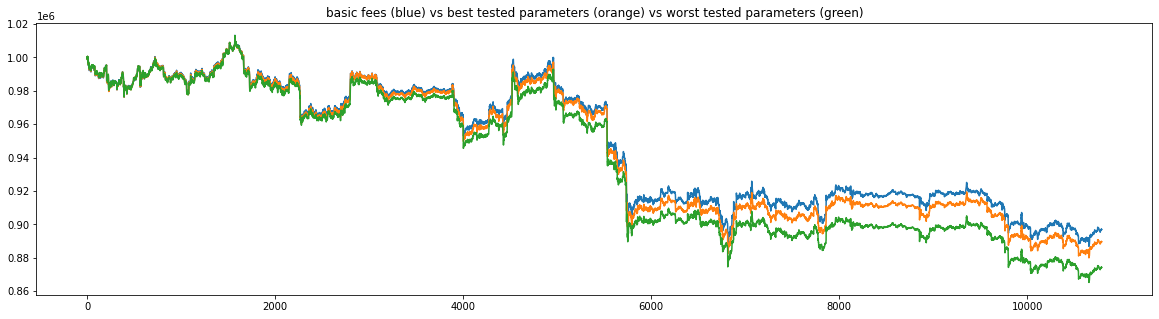

In [9]:
plt.figure(figsize=(20, 5))
LP_holdings1 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]]
LP_holdings2 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events2[::20]]
LP_holdings3 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events3[::20]]

plt.plot(range(len(LP_holdings1)), LP_holdings1)
plt.plot(range(len(LP_holdings2)), LP_holdings2)
plt.plot(range(len(LP_holdings2)), LP_holdings3)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

Text(0.5, 1.0, 'basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

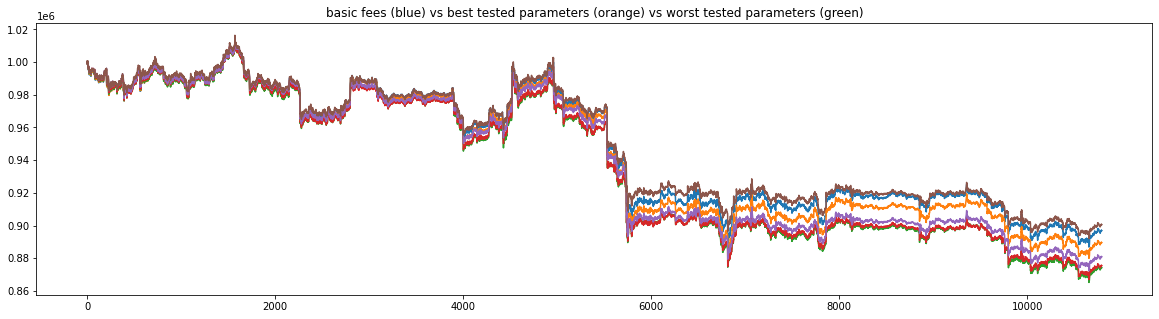

In [10]:
plt.figure(figsize=(20, 5))
for events in events_list:
    LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]]
    plt.plot(range(len(LP_holdings)), LP_holdings)
# LP_holdings1 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]]
# LP_holdings2 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events2[::20]]
# LP_holdings3 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events3[::20]]
#
# plt.plot(range(len(LP_holdings1)), LP_holdings1)
# plt.plot(range(len(LP_holdings2)), LP_holdings2)
# plt.plot(range(len(LP_holdings2)), LP_holdings3)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

Text(0.5, 1.0, 'external dot price')

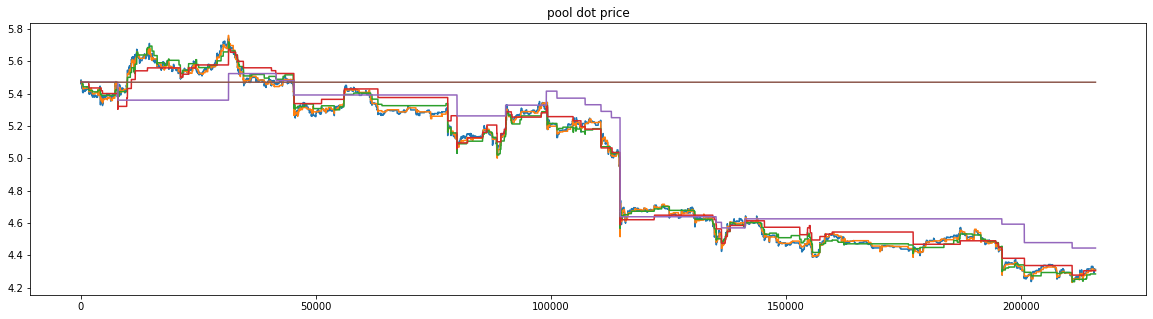

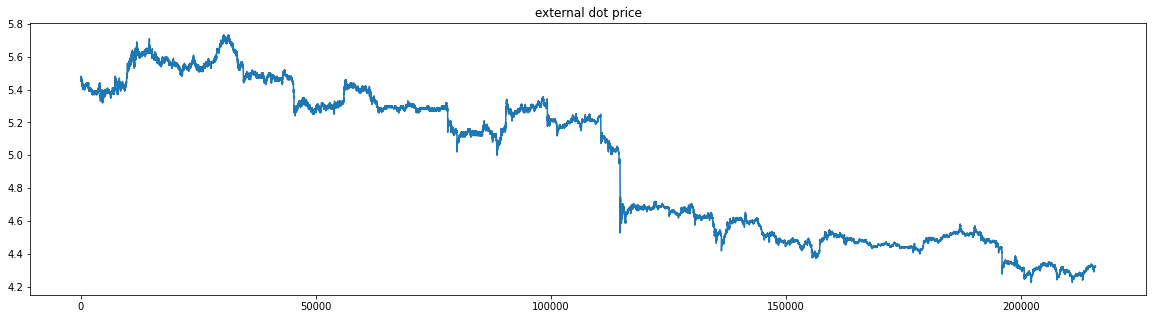

In [23]:
from model.amm.omnipool_amm import usd_price
plt.figure(figsize=(20, 5))
for events in events_list:
    dot_price = [usd_price(event.pools['omnipool'], 'DOT') for event in events]
    plt.plot(range(len(dot_price)), dot_price)
plt.title('pool dot price')

plt.figure(figsize=(20, 5))
dot_price = [event.external_market['DOT'] for event in events_list[0]]
plt.plot(range(len(dot_price)), dot_price)
plt.title('external dot price')

In [12]:
print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])


896894.2566579923
889522.2136926097
874173.5512966783


In [13]:
random.seed(42)
basic_state2 = initial_state.copy()
basic_state2.pools['omnipool'].asset_fee=0.0025
basic_state2.pools['omnipool'].lrna_fee=0.0005

events4=run.run(basic_state2, time_steps=time_steps)
LP_holdings4 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events4[::20]]


Starting simulation...
Execution time: 29.048 seconds.


In [14]:
random.seed(42)
basic_state3 = initial_state.copy()
basic_state3.pools['omnipool'].asset_fee=0.0025
basic_state3.pools['omnipool'].lrna_fee=0.0005

events5=run.run(basic_state3, time_steps=time_steps)
LP_holdings5 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events5[::20]]


Starting simulation...
Execution time: 24.542 seconds.


In [15]:

print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])
print(LP_holdings4[-1])
print(LP_holdings5[-1])


896894.2566579923
889522.2136926097
874173.5512966783
896894.2566579923
896894.2566579923


In [16]:
# print(events[0], events[1000])

In [17]:
# print(winning_state, losing_state)

<AxesSubplot:title={'center':'asset price: DOGE '}>

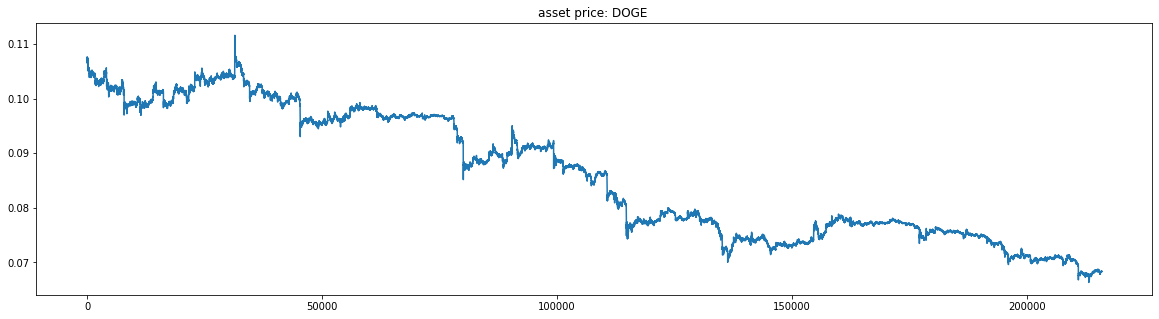

In [18]:
pu.plot(events, asset='DOGE')

<AxesSubplot:title={'center':'omnipool fee_raise volume_in DOT '}>

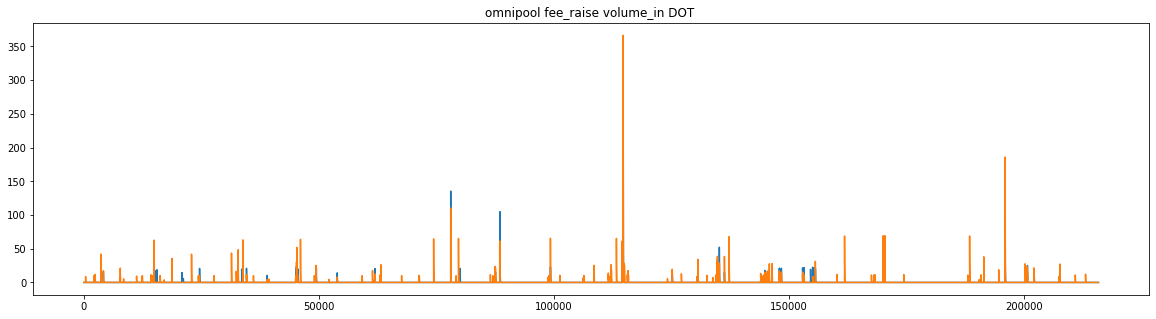

In [19]:
ax = pu.plot(events, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT')
pu.plot(events2, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT', subplot=ax)

In [20]:
# print(test_results[0])
# print(test_results[-1])

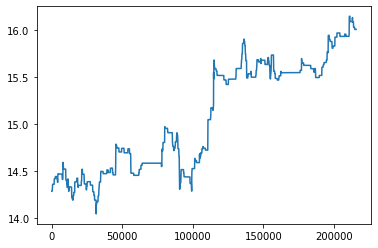

In [21]:
volume_out_usd = [event.pools['omnipool'].oracles['fee_raise'].price['USD'] for event in events3]
plt.plot(range(len(volume_out_usd)), volume_out_usd)

In [22]:
reverse_price_list = list(reversed(processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=30)))
reverse_basic_state = initial_state.copy()
reverse_basic_state._evolve_function=historical_prices(reverse_price_list)
reverse_basic_events = run.run(reverse_basic_state, time_steps = time_steps)

reverse_state = reverse_basic_state.copy()
reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[-1].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].lrna_decay,
    fee_max=test_results[-1].lrna_max,
)
reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[-1].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].asset_decay,
    fee_max=test_results[-1].asset_max,
)
reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
reverse_events = run.run(reverse_state, time_steps = time_steps)

worst_reverse_state = reverse_state.copy()
worst_reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[0].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].lrna_decay,
    fee_max=test_results[0].lrna_max,
)
worst_reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[0].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].asset_decay,
    fee_max=test_results[0].asset_max,
)
worst_reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
worst_reverse_events = run.run(worst_reverse_state, time_steps = time_steps)


Starting simulation...


KeyboardInterrupt: 

In [ ]:
reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_events[::20]]
worst_reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in worst_reverse_events[::20]]
reverse_basic_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_basic_events[::20]]
plt.figure(figsize=(20, 5))
plt.plot(range(len(reverse_LP_holdings)), reverse_basic_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), reverse_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), worst_reverse_LP_holdings)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green) with price movement reversed')

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(price_list)), [price_list[i]['ETH'] for i in range(len(price_list))])
plt.plot(range(len(price_list)), [reverse_price_list[i]['ETH'] for i in range(len(price_list))])
plt.title('two different, opposite price runs')

In [ ]:
pu.plot(reverse_events, asset='ETH')

In [ ]:
pu.plot(reverse_events[::100], agent='Trader', prop='holdings', key='ETH')

In [ ]:
oracle = [event.pools['omnipool'].oracles['fee_raise'].volume_in['ETH'] for event in reverse_events][:100]
plt.plot(range(len(oracle)), oracle)

In [ ]:
pu.plot(reverse_events[::20], pool='omnipool', prop='last_fee')
pu.plot(reverse_events[::20], pool='omnipool', prop='last_lrna_fee')

pu.plot(events2[::20], pool='omnipool', prop='last_fee')
pu.plot(events2[::20], pool='omnipool', prop='last_lrna_fee')


In [ ]:
pu.plot(events[::20], pool='omnipool', oracle='fee_raise', prop='liquidity', key='HDX')